In [33]:
import xgboost as xgb
import numpy as np
import time
from sklearn import datasets
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, roc_curve, precision_recall_curve
import pandas as pd
import sklearn.model_selection as msel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

# wizualizacja
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
base_color = sns.color_palette()[0]

import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore')

In [90]:
df = pd.read_csv("data_for_aviation_model.csv")
df.head()

,Event.Date,Location,Country,Injury.Severity,Aircraft.damage,Aircraft.Category,Make,Model,Amateur.Built,Number.of.Engines,...,Weather.Condition,Broad.phase.of.flight,Report.Status,States,Year,Month.Abbr,Day.Name.Abbr,Weekend,Model.Capacity,Capacity
0,1982-01-01,"PULLMAN, WA",United States,Non-Fatal,Substantial,Airplane,cessna,140,No,1.0,...,VMC,Takeoff,Probable Cause,WA,1982,Jan,Fri,False,cessna_small,small
1,1982-01-01,"EAST HANOVER, NJ",United States,Non-Fatal,Substantial,Airplane,cessna,401b,No,2.0,...,IMC,Landing,Probable Cause,NJ,1982,Jan,Fri,False,cessna_medium,medium
2,1982-01-01,"JACKSONVILLE, FL",United States,Non-Fatal,Substantial,Airplane,north american,navion l17b,No,1.0,...,IMC,Cruise,Probable Cause,FL,1982,Jan,Fri,False,namerican_medium,medium
3,1982-01-01,"HOBBS, NM",United States,Non-Fatal,Substantial,Airplane,piper,pa28161,No,1.0,...,VMC,Approach,Probable Cause,NM,1982,Jan,Fri,False,piper_medium,medium
4,1982-01-01,"TUSKEGEE, AL",United States,Non-Fatal,Substantial,Airplane,beech,v35b,No,1.0,...,VMC,Landing,Probable Cause,AL,1982,Jan,Fri,False,beech_medium,medium


In [91]:
df = df.drop(['Injury.Severity', 'Weekend', 'Year', 'Day.Name.Abbr', 'Month.Abbr', 'Event.Date', 'Location', 'Country', 'Model', 'Make', 'Report.Status', 'States', 'Model.Capacity'], axis=1)


In [93]:
df['Total.Fatal.Injuries'] = df['Total.Fatal.Injuries'].apply(lambda x: 0.0 if x == 0.0 else 1.0)


In [94]:
df['Total.Serious.Injuries'] = df['Total.Serious.Injuries'].apply(lambda x: 0.0 if x == 0.0 else 1.0)


In [95]:
df['Total.Minor.Injuries'] = df['Total.Minor.Injuries'].apply(lambda x: 0.0 if x == 0.0 else 1.0)


In [96]:
df['Total.Uninjured'] = df['Total.Uninjured'].apply(lambda x: 0.0 if x == 0.0 else 1.0)


In [97]:
df['Total.Minor.Injuries'] = df['Total.Minor.Injuries'].astype(object)
df['Number.of.Engines'] = df['Number.of.Engines'].astype(object)
df['Total.Fatal.Injuries'] = df['Total.Fatal.Injuries'].astype(object)
df['Total.Serious.Injuries'] = df['Total.Serious.Injuries'].astype(object)
df['Total.Uninjured'] = df['Total.Uninjured'].astype(object)

In [98]:
df = df.drop(df[df['Aircraft.damage'] == 'Minor'].index)

In [99]:
df['Aircraft.damage'].value_counts()

Substantial    46274
Destroyed      12386
Name: Aircraft.damage, dtype: int64

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61399 entries, 0 to 61398
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Aircraft.damage         60203 non-null  object
 1   Aircraft.Category       61399 non-null  object
 2   Amateur.Built           61385 non-null  object
 3   Number.of.Engines       60751 non-null  object
 4   Engine.Type             60055 non-null  object
 5   Purpose.of.flight       59634 non-null  object
 6   Total.Fatal.Injuries    61399 non-null  object
 7   Total.Serious.Injuries  61399 non-null  object
 8   Total.Minor.Injuries    61399 non-null  object
 9   Total.Uninjured         61399 non-null  object
 10  Weather.Condition       61007 non-null  object
 11  Broad.phase.of.flight   49919 non-null  object
 12  Capacity                54245 non-null  object
dtypes: object(13)
memory usage: 6.1+ MB


In [100]:
df['Aircraft.damage_cat'] = (df['Aircraft.damage'] != 'Destroyed').astype('int8')

In [101]:
# funkcja zwracająca cechy jakościowe
def get_cat_features(dataframe):
    feats = dataframe.select_dtypes(np.object).columns
    black_list = ['Aircraft.damage']
    return [x for x in feats if x not in black_list]

In [102]:
cat_feats = get_cat_features(df)

In [103]:
df = pd.get_dummies(data=df, columns=cat_feats, drop_first=True)

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59856 entries, 0 to 61398
Data columns (total 48 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   Aircraft.damage                              58660 non-null  object
 1   Aircraft.damage_cat                          59856 non-null  int8  
 2   Aircraft.Category_Helicopter                 59856 non-null  uint8 
 3   Amateur.Built_Yes                            59856 non-null  uint8 
 4   Number.of.Engines_2.0                        59856 non-null  uint8 
 5   Number.of.Engines_3.0                        59856 non-null  uint8 
 6   Number.of.Engines_4.0                        59856 non-null  uint8 
 7   Number.of.Engines_6.0                        59856 non-null  uint8 
 8   Engine.Type_turbo fan                        59856 non-null  uint8 
 9   Engine.Type_turbo jet                        59856 non-null  uint8 
 10  Engine.Typ

In [105]:
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold


In [106]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

random_state=2023

In [107]:
# funkcja podobna do powyższej, tylko wyłapujemy cechy, których nie chcemy użyć w modelu

black_list = ['Aircraft.damage_cat']

def get_model_features(dataframe, black_list):
    feats = dataframe.select_dtypes([np.number, np.bool]).columns
    return [x for x in feats if x not in black_list]

In [108]:
# przypisujemy X i y
feats = get_model_features(df, black_list)

X = df[feats]
y = df['Aircraft.damage_cat']

In [109]:
# dzielimi na train i test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state)

print("Train samples: {}.".format(X_train.shape[0]))
print("Test samples: {}.".format(X_test.shape[0]))

Train samples: 47884.
Test samples: 11972.


In [110]:
def run_model(model, X, y, cross_val):
    """
    funkcja przeprowadzająca trening na liście modeli

    input:
            model: model estymatora z pakietu sklearn
            X: cechy do przeprowadzenia uczenia
            y: target
            cross_val: rodzaj walidacji
    output/print:
            fbeta_res: wynik fbeta na każdy fold / później uśredniony
            accuracy_res: wynik accuracy na każdy fold / później uśredniony
            cross_val_time: total scoring time dla obu metryk
    """
    model_name = type(model).__name__

    fbeta_scorer = make_scorer(fbeta_score, beta=0.5)
    
    start = time.time()
    fbeta_res = cross_val_score(model, X, y, cv=cross_val, scoring=fbeta_scorer)
    accuracy_res = cross_val_score(model, X, y, cv=cross_val, scoring='accuracy')
    end = time.time()
    cross_val_time = end - start
    print("{} fbeta: {:.4f}, accuracy: {:.4f}, time: {}".format(model_name, np.mean(fbeta_res), np.mean(accuracy_res), cross_val_time))
    

In [111]:
# funkcja rysująca ważność cech
def plot_feature_importances(model, feat_list, ax):

  model_name = type(model).__name__
  skplt.estimators.plot_feature_importances(model, feature_names=df[feat_list].columns,
                                            title=f'{model_name} feature importances', ax=ax)
  plt.xticks(rotation=90)

In [112]:
# zdefiniowanie walidacji
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)

# zdefiniowanie prostych modeli
Dummy_model = DummyClassifier(strategy="stratified") 
LR_model = LogisticRegression()
DT_model = DecisionTreeClassifier(random_state=random_state)
RF_model = RandomForestClassifier(random_state=random_state)
XGB_model = XGBClassifier(eval_metric='error', random_state=random_state)
Gaussian_model = GaussianNB()
KNN_model = KNeighborsClassifier()


# dodanie modeli do listy, po której będziemy iterowali
models = [Dummy_model, LR_model, DT_model, RF_model, XGB_model, Gaussian_model, KNN_model]


In [113]:
# ewaluacja modeli
for model in models:
    run_model(model, X_train, y_train, skf)

DummyClassifier fbeta: 0.7950, accuracy: 0.6736, time: 0.16749119758605957
LogisticRegression fbeta: 0.9155, accuracy: 0.8879, time: 2.6580522060394287
DecisionTreeClassifier fbeta: 0.9122, accuracy: 0.8751, time: 1.084428071975708
RandomForestClassifier fbeta: 0.9132, accuracy: 0.8819, time: 20.820443868637085
XGBClassifier fbeta: 0.9158, accuracy: 0.8871, time: 19.69876718521118
GaussianNB fbeta: 0.7803, accuracy: 0.5661, time: 0.5079143047332764
KNeighborsClassifier fbeta: 0.9108, accuracy: 0.8719, time: 72.18018198013306


In [114]:
# fit models
for model in models:
    model.fit(X_train, y_train)

In [115]:
# wyniki predykcji
y_pred_Dummy_model = Dummy_model.predict(X_test)
y_pred_LR_model = LR_model.predict(X_test)
y_pred_DT_model = DT_model.predict(X_test)
y_pred_RF_model = RF_model.predict(X_test)
y_pred_XGB_model = XGB_model.predict(X_test)
y_pred_Gaussian_model = Gaussian_model.predict(X_test)
y_pred_KNN_model = KNN_model.predict(X_test)

In [116]:
# sprawdzenie fbeta_score dla każdego modelu między wynikami predykcji
# a rzeczywistymi wartościami ze zbioru treningowego
fbeta_Dummy = fbeta_score(y_test, y_pred_Dummy_model, beta=0.5)
fbeta_LR = fbeta_score(y_test, y_pred_LR_model, beta=0.5)
fbeta_DT = fbeta_score(y_test, y_pred_DT_model, beta=0.5)
fbeta_RF = fbeta_score(y_test, y_pred_RF_model, beta=0.5)
fbeta_XGB = fbeta_score(y_test, y_pred_XGB_model, beta=0.5)
fbeta_Gaussian = fbeta_score(y_test, y_pred_Gaussian_model, beta=0.5)
fbeta_KNN = fbeta_score(y_test, y_pred_KNN_model, beta=0.5)

results = [fbeta_Dummy, fbeta_LR, fbeta_DT, fbeta_RF, fbeta_XGB, fbeta_Gaussian, fbeta_KNN]

In [117]:
print("-----Wyniki f-beta na zbiorze testowym-----")
print("Dummy f-beta: {:.4f}".format(fbeta_Dummy))
print("Logistic Regression f-beta: {:.4f}".format(fbeta_LR))
print("Decision Tree f-beta: {:.4f}".format(fbeta_DT))
print("RandomForest f-beta: {:.4f}".format(fbeta_RF))
print("XGBoost f-beta: {:.4f}".format(fbeta_XGB))
print("Gaussian f-beta: {:.4f}".format(fbeta_Gaussian))
print("KNN f-beta: {:.4f}".format(fbeta_KNN))

-----Wyniki f-beta na zbiorze testowym-----
Dummy f-beta: 0.7911
Logistic Regression f-beta: 0.9163
Decision Tree f-beta: 0.9156
RandomForest f-beta: 0.9156
XGBoost f-beta: 0.9176
Gaussian f-beta: 0.7405
KNN f-beta: 0.9068


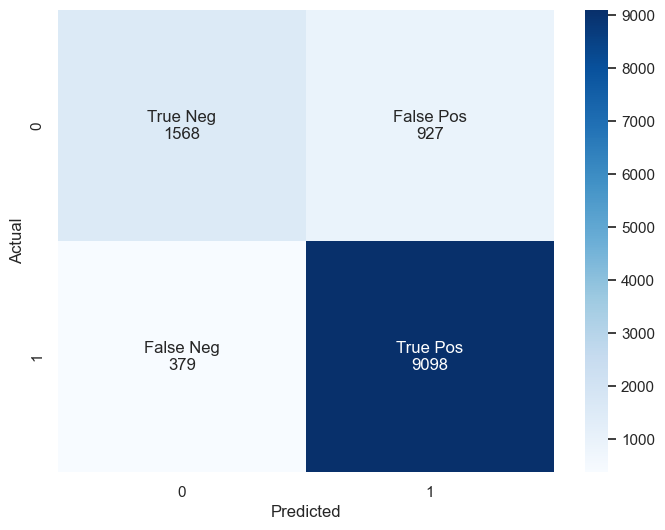

In [118]:
cf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_XGB_model)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()] #flatten() 'splaszcza' matryce

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

sns.set(rc={'figure.figsize':(8,6)})
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set(xlabel='Predicted', ylabel='Actual');

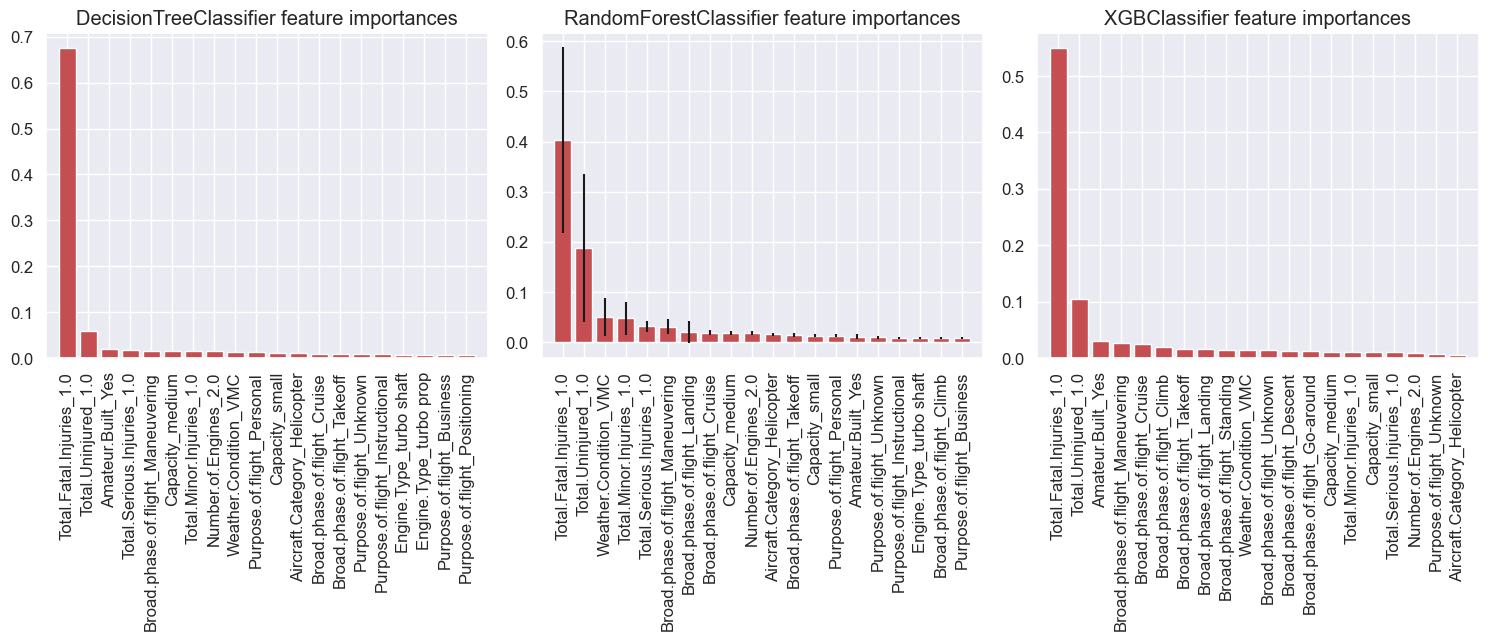

In [119]:
fig=plt.figure(figsize=(20,10))
for i, model in enumerate(models[2:5]):
    ax=fig.add_subplot(2,4,i+1)
    plot_feature_importances(model, feats, ax=ax)
fig.tight_layout()
plt.show()